# Final Notebook

<b>Title:</b> Hotel Review Analysis Using NLP and Machine Learning

<b>Author:</b> Ismael Araujo


## Overview
In this project, I will create a model that can predict if a hotel review is negative or positive so that hotels can use it to classify their reviews correctly. I will analyze a specific hotel in London and compare it to other hotels in London as well. We will walk through multiple Natural Language Processing to understand how we can use machines to read reviews and get insights out of it. Baseline models include Logistic Regression, Random Forest, Naive Bayes, and Support Vector Machine (SVM). Ensemble models include Voting, Bagging, GridSearch, AdaBoost, and Gradient Boosting. The final model was a GridSearch SVM with an accuracy of 0.8268 and F1-Score 0.8247.

This project walks through exploratory data analysis, data cleaning, sentiment analysis, data preprocessing, vanilla models, and ensemble models.

# Business Problem

One of the biggest problems that many companies have been trying to overcome is how to take advantage of all the data collected from guests. The amount of data has challenged the travel industry. One type of data is reviews left by guests on websites such as Booking.com, TripAdvisor, and Yelp.

Hotels have been trying to find ways to analyze the reviews and get insights out of them. However, some hotels can receive thousands of guests every week and hundreds of reviews. It becomes nearly impossible and expensive for hotels to keep track of the reviews. Thus, multiple hotels might ignore these valuable data due to the cost and energy that need to be allocated. The other problem is that hotels such as Booking.com don't allow users to choose their score. The score is determined by questions asked to the user, and then the review is calculated. This is problematic because guests could have had a bad experience, and the hotel would still get a 7 or 8 score, which gives a false illusion that the guest didn't have any problems.

This project will build a model that can correctly predict if a hotel review is negative or positive so that hotels can input their reviews and get a non-biased score.

## Setting the hypothetical scenario

Our actual client is a hotel in London called Britannia International Hotel Canary Wharf. They have thousands of reviews and a 6.7 overall score on Booking.com. They think this is a low score compared to other London hotels, and they want to understand what is causing this low score. Due to COVID-19, they don't have the resources to read all the reviews and make sense of them. Thus, they want to find a way to get quick insights without having to read every review. They have a few business questions:

- Can we create a model that can correctly identify the most important features when predicting if a review is positive or negative for all the reviews we have available? What are these features?
- What are the most mentioned words in negative and positive reviews? What insights could they get from them? How would a word cloud for negative and positive reviews look like for their hotel and in comparison to other hotels?
- How does the client score performs compared to other hotels in the city?

### Why Britannia International Hotel Canary Wharf?

While doing the Exploratory Data Analysis, I noticed that Britannia International Hotel Canary Wharf was the hotel with the highest number of reviews. The average score is 6.7, which means that there is probably room for improvement. It is more likely to find different word clouds for negative and positive reviews.

## Data and Methods

The dataset for this project was originally used in the study Text Mining in Hotel Reviews: Impact of Words Restriction in Text Classification by Diego Campos, Rodrigo Rocha Silva, and Jorge Bernadino and a team at University of Coimbra. The raw dataset is from Kaggle. The original dataset had 515,738 observations and 17 columns.

<img src="images/feature-columns.png">

## Challenges

The data set was quite organized. However, it had a few challenges. For example, the review was divided between positive and negative reviews. Although this is useful for specific cases, most reviews will not be separated by positive and negative reviews. Thus, creating a model that is able to identify positive and negative reviews could be useless if we add reviews that are not separated. Other uses for the model, such as using it in social media, would not work. A solution was merging them.
Another big challenge with the dataset is that the address is a long string, which means that it is difficult to collect information such as city and country due to the different written formats. This problem was solved by grabbing the city and country of the hotel using Geopy.

## Data Understanding

Data understanding was a very important step in this project. I was able to understand the dataset. The first thing I noticed was that the dataset was very large. This could be a problem when modeling. Thus, for the MVP, I decided to use only 20% of the dataset to avoid the curse of dimensionality.

Since I had a classification problem, I first created a target feature with the score. In this step, I noticed that the lowest score was 2.5 and the highest was 10. Since there were users who wrote that there was anything good about the hotel, I assume that Booking.com, not the user, actually gave 2.5. Then I converted the score into a classification problem. Since 2.5 was the lowest and 10 the highest, I decided to divide the target in two: positive and negative, where anything below 6 was negative, and 6 and above was positive. 6.25 would be the middle point, so I decided to go with 6.

### Data Cleaning

As in any NLP project, data cleaning is the most important step. We need to make sense of the information we have and create features for the models only with the information that matters. A few cleaning steps that I took were:

- Remove any punctuations, stop words, and numbers
- Fix the spelling using TextBlob
- Lemmatization
- Remove words from the word clouds that didn't help with insights, such as complimentary adjectives (great, good, nice, excellent, etc.)

Let's see how it was done.

In [1]:
# Importing Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

# NLP Packages
import nltk 
from nltk.corpus import stopwords
from textblob import TextBlob 
from textblob import Word
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
import eli5



# WordCloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Pandas Settings
pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 100)

# Solve warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Importing all functions used in this notebook
from functions import *

In [3]:
# Import csv file
df = pd.read_csv('csv/Hotel_Reviews.csv')

The idea in this step is to take a look at the data. A key points that I want to investigate are:
- Shape of the dataset
- If there are null values
- How many unique hotels and if it matches to the value said in the dataset
- The types of data

In [4]:
# DataFrame shape
df.shape

(515738, 17)

Here we can see that the dataset is large. Some models could take way too long to run a train set this size. Thus, in the first part of this project, I will use 20% of the original dataset. Further in the project, I'm planning on testing best model on the entire dataset. Luckily, since the dataset is so large, we can fix any class imbalance here.

In [5]:
# Selecting only the columns that I will use
features = ['Hotel_Name', 'Negative_Review','Positive_Review', 'Reviewer_Score']
df = df[features]

For NLP, I want to see how the model performs having the positive reviews together, since that's the way that most people write reviews.

In [6]:
# Putting reviews together
df['Reviews'] = df['Negative_Review'] + df['Positive_Review']

In [7]:
# Keep only 20% of the dataframe
df = df.sample(frac=0.20, random_state=1)

In [8]:
# Checking the hotel with the highest number of reviews
df.pivot_table(index=['Hotel_Name'], aggfunc='size').nlargest()

Hotel_Name
Britannia International Hotel Canary Wharf           965
Strand Palace Hotel                                  900
Park Plaza Westminster Bridge London                 846
Copthorne Tara Hotel London Kensington               748
DoubleTree by Hilton Hotel London Tower of London    641
dtype: int64

We now have only 20% of the dataset. We can see that Britannia International Hotel Canary Wharf is still the hotel with the most reviews, which shows us that pandas sample function really works as expected. I mentioned this in the <a href="https://github.com/Ismaeltrevi/hotel-reviews-analysis-using-nlp/blob/main/preprossessing/eda.ipynb">EDA</a> notebook.

Now it's time to clean data. The function below lowercase all the words, removes punctuations, and digits.

In the <a href="https://github.com/Ismaeltrevi/hotel-reviews-analysis-using-nlp/blob/main/preprossessing/eda.ipynb">EDA</a> notebook I explain that the lowest score is 2.5, which I believe the users don't have the option to choose the score and it must be automatic. For this reason, there are only scores between 2.5 and 10. For this reason, I choose the half point between these two numbers to create my variable.

In [9]:
# Applying clean_text_round1 function
df['Reviews_Clean'] = pd.DataFrame(df.Reviews.apply(round1))

Create a binary classification where anything below 6 is negative review and 6 and above is positive.

In [10]:
# Create function that turns the Reviewer Score into a classification target with 3 values
df['Score'] = df['Reviewer_Score'].apply(lambda x: 0 if x < 6 else 1)

### Class Distribution

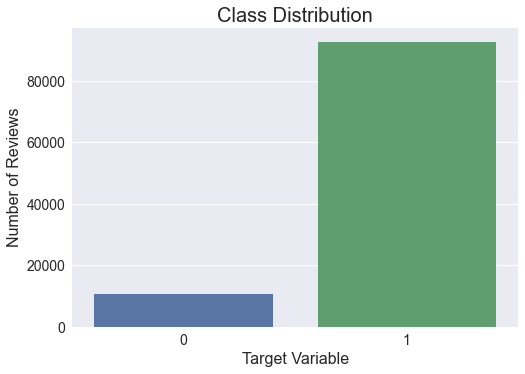

In [11]:
# Checking if the target variable is balanced
plt.style.use('seaborn')
sns.countplot(df['Score'])
plt.title('Class Distribution', fontsize=20)
plt.xlabel('Target Variable', fontsize=16)
plt.ylabel('Number of Reviews', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

We can see that there is a big class imbalance. Since our dataset is large, we can fix this using the pandas sample function. Thus, I will only use 12% of the positive reviews for this stage, which will get closer to the number of negative reviews, so it will get closer to the number of negative reviews.

The reason why I removed the preprocessing manually is to make the spell checker faster, since it takes more than 24 hours to check 100k. As a next step, I will keep the class imbalance for the modeling stage.

In [12]:
# Creating separate dataframes depending on the classification
df_Score_0 = df[df.Score == 0]
df_Score_1 = df[df.Score == 1].sample(frac=0.12)

In [13]:
# Concatenating th 
df = pd.concat([df_Score_1, df_Score_0])
df.shape

(21620, 7)

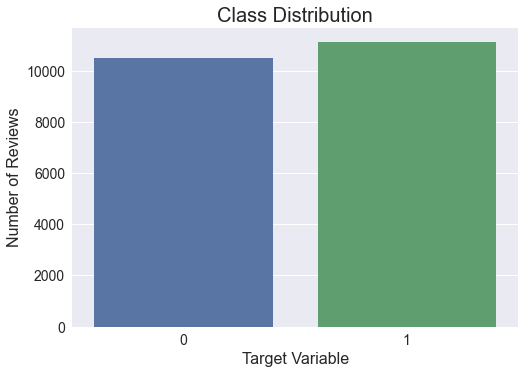

In [14]:
# Checking if the target variable is balanced
sns.countplot(df['Score'])
plt.title('Class Distribution', fontsize=20)
plt.xlabel('Target Variable', fontsize=16)
plt.ylabel('Number of Reviews', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

We can see above that the class distribution problem was solved.

### Spell Checker

Let's fix any spelling mistakes in the review using TextBlob. But first, let's take a look at how many unique words we have.

In [15]:
# Setting stop words
stop_words = stopwords.words('english')

In [16]:
# Instantiate CountVectorizer
cv = CountVectorizer(stop_words=stop_words)

# Fit and transform dataframe without data cleaning
df_cv = cv.fit_transform(df['Reviews_Clean'])
df_cv.shape

(21620, 17695)

We can see that we have 17,855 words. Let's see if we can reduce this number after using the spell checker with TextBlob.

<b>IMPORTANT NOTE:</b>

The cell below exports the dataset with the spelling checked. If you export it without running the Spell Checker, all the models won't have the target correctly set up. Thus, I don't recommend exporting that cell.

⏳ The cell below takes around 1h 20m to run. Uncomment it to run.

In [17]:
# # Checking if function works
# df['Spell_Checked'] = df['Reviews_Clean'].apply(lambda x: ''.join(TextBlob(x).correct()))

# 1h 21m to run

In [18]:
# Importing the dataset with the spelling checked
df = pd.read_csv('csv/Hotel_Review_Spell_Checked.csv', index_col=0)

Let's now use count vectorizer to count how unique many words we have left.

In [19]:
# Fit and transform dataframe without data cleaning to check how many unique words we have
df_cv = cv.fit_transform(df['Spell_Checked'])
df_cv.index = df.index
df_cv.shape

(21619, 11930)

Done! We reduced our dataset from 17,836 words to 11,930 words. This will speed up the model iterations and avoid the curse of dimemntionality.

## Exploratory Data Analysis

<b>IMPORTANT NOTE:</b> EDA and visualizations use multiple lines of code. To keep this notebook clean, I will only add the images here. All of the following images are in the EDA notebook. 
<b>If you are interested in checking the process, please check the <a href="https://github.com/Ismaeltrevi/hotel-reviews-analysis-using-nlp/blob/main/preprossessing/eda.ipynb">EDA notebook clicking here</a></b>.

Now, let's go back to the EDA.

I wanted a few answer from the dataset and check if I could find any patterns. Thus, I had questions, which I will answer right next:

#### What nationalities give the highest number of reviews?

<img src="images/nationality.png">

Reviewers from the United Kingdom have the highest number of reviews left. To understand the main reason behind this, I checked where the hotels with the highest reviews are located. In the next image we can understand two things:

- The hotels are located in only 6 countries only, not the whole Europe, as I previously thought.
- The reviewers are mostly from the UK (over 50%), which explain the higher number of people from the UK giving reviews.

<img src="images/countries-hotels.png">

#### How does the hotel which I will focus on perform compared to other hotels in London?

<img src="images/score-density-hotel-vs-london.png">

As we can see above, the Britannia International Hotel Canary Wharf underperform compared to other hotels in London. While the hotels in London have the score density skewed to the right where the positive scores are, Britannia International Hotel Canary Wharf is closer to a evenly distribution, where the amount of negative reviews are as high as the negative reviews. This tells as the the hotel has a lot to improve.

For the results section, I had two question in mind:

- What words appear the most in positive and negative reviews?
- Can we get any insights from it?

To get these answers, I had to clean the data through different steps. You can see more details of each step in the Data Cleaning notebook. Now let's check the word clouds and see if we can get insights from it.

Below we can see the positive reviews word cloud. Note that you can relate every word to things that you could image coming from a hotel review. For example, we can see the words location, clean, comfortable, staff, service, price, and room. We can certainly assure that these are high points to the hotel and they can use these words to promote the hotel.

<img src="images/positive_wordcloud.png">

On the other hand, looking at the negative reviews word cloud, we can see many words that could be points for improvement to the hotel. Staff seems it’s mentioned multiple times as well as the word rude and reception. Maybe the staff was rude to these guests? We can also see the words old, dated, dirty, and uncomfortable, which could be points of attention to the management.

<img src="images/negative_wordcloud.png">

If you are interested in more EDA, please take a look at the <a href="https://github.com/Ismaeltrevi/hotel-reviews-analysis-using-nlp/blob/main/preprossessing/eda.ipynb">EDA</a> notebook.

### Sentiment Analysis

In this step we will create a sentiment analysis and compare the performance the actual score that users give. I want to visualize if the sentiment analysis can do a better job analysing when a review is negative or positive. 

In this step we will create a sentiment analysis and compare the performance the actual score that users give. I want to visualize if the sentiment analysis can do a better job analysing when a review is negative or positive. 

In [20]:
# Import csv file
df = pd.read_csv('csv/Hotel_Reviews.csv')

In [21]:
# Selecting only the columns that I will use
features = ['Negative_Review','Positive_Review', 'Reviewer_Score']
df = df[features]

<b>NOTE:</b>

The following cell takes around 10 minutes to run. For this reason, I will  upload the dataframe with the sentiment analysis already in it. If you want to run it, please uncomment the cell.

In [22]:
# # Create new columns to compare polarity and subjetivity on Negative Reviews
# df['Polarity_Net'] = df['Negative_Review'].apply(getPolarity)
# df['Polarity_Pos'] = df['Positive_Review'].apply(getPolarity)

In [23]:
# Importing DataFrame with new Polarity column
df = pd.read_csv("csv/df_sentiment_analysis.csv", index_col=0)

In [24]:
# Creating function to classify the Sentiment Analysis
df['Sent_Analysis_Neg'] = df['Polarity_Net'].apply(lambda x: 0 if x < 0 else 1 if x > -0.1 and x < 0.1 else 2)
df['Sent_Analysis_Pos'] = df['Polarity_Pos'].apply(lambda x: 0 if x < 0 else 1 if x > -0.1 and x < 0.1 else 2)

In [25]:
# Create a score column
df['Score'] = df['Reviewer_Score'].apply(lambda x: 0 if x < 6 else 1)## Evaluation Results

## Evaluation Results

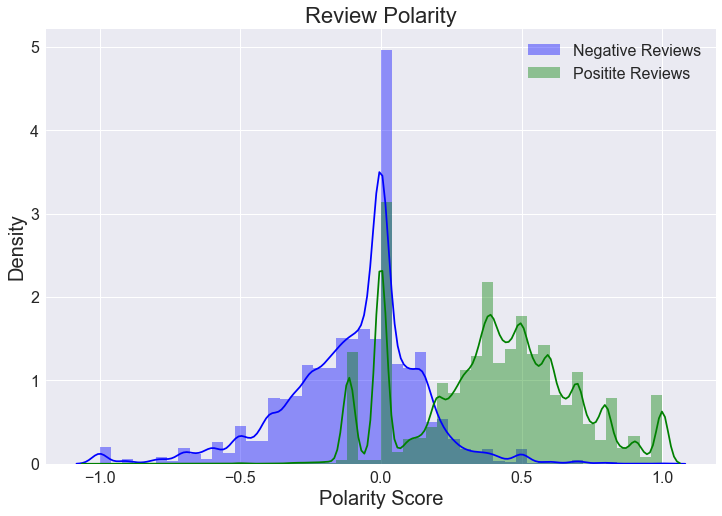

In [26]:
# Creating density plot for the labels polaritu scores
plt.figure(figsize=(12, 8))
ax = sns.distplot(df['Polarity_Net'][df['Score'] == 0], label='Negative Reviews', color='blue')
ax = sns.distplot(df['Polarity_Pos'][df['Score'] == 1], label='Positite Reviews', color='green')

# Setting label, title and legend
ax.set_title('Review Polarity', fontsize=22)
ax.set_ylabel('Density', fontsize=20)
ax.set_xlabel('Polarity Score', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.legend(prop=dict(size=16))
plt.savefig('images/sentiment_analysis.png', bbox_inches = "tight", pad_inches=.5, dpi=300)
plt.show()

The graph above shows that the sentiment analysis does a good job identifying positive reviews with a positive polarity. However, it does not perform as well with the negative reviews. We can see that there is a big number of neutral reviews where sentiment analysis couldn't understand if the review was positive or negative.

### Findings and Takeaways:

- It was created Subjectivity and Polarity features using sentiment analysis for Negative and Positive Reviews. 
- Polarity ranges between -1 and 1. Where -1 means that the review was very negative and 1 means that the review was very positive
- Seems like sentiment analysis does a good job identifying positive reviews, but the negative reviews could be improved

Using the density plot to analyze the sentiment analysis, we can see that most are concentrated in the neutral reviews. We know from the EDA that most reviews are mostly positive. Also we can see that it identifies correctly the positive reviews with higher precision, but it doesn't perform as well for the negative reviews.

# Modeling

For the modeling, I started with the vanilla models. I had four models in mind that I believe would potentially perform the best results for NLP. Then, I test ensemble models to improve the performance of the best vanilla models. Let's see the results.

You can see all the process in the <a href="https://github.com/Ismaeltrevi/hotel-reviews-analysis-using-nlp/blob/main/models/baseline-models.ipynb">vanilla models</a> notebook and in the <a href="https://github.com/Ismaeltrevi/hotel-reviews-analysis-using-nlp/blob/main/models/ensemble-models.ipynb">ensemble models</a> notebook.
    
    
    

In [27]:
# Sklearn Packages
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import resample
from sklearn.ensemble import BaggingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from IPython.core.display import display, HTML

# Import pickle
import pickle

## Preprocessing

In [28]:
df = pd.read_csv("csv/Hotel_Review_Spell_Checked.csv", index_col=0)

In [29]:
# Creating an X variable and y for my target
X = df.Spell_Checked
y = df.Score

### Train Test Split

As mentioned in the introduction, I will use the column `Spell_Checked` to create the features and `Score` as my target. Since the model iterations had different results with different vectorizers, I will also pickle the train and test sets as they were in the original notebook.

In [30]:
# Splitting the dataset in train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [31]:
# Instantiate TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words=stop_words)

# Fitting into the train and test set
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

### Evaluation Metric

The evaluation metric below will simplify the model evaluation. My main focus is the accuracy metric. Have an accurate is important to be accurate. However, although fixing False Negatives is not crucial, I will also take a look at Recall and F1-Score to understand how my model is working. Since it is not my main focus, I will not mentioned in the individual analysis on my models.

## Vanilla Models

For the modeling process, I chose multiple models, testing them with different vectorizers in different stages of data cleaning. For the baseline models, I ran Logistic Regression, Random Forest, Naive Bayes, and Support Vector Machine.

I ran the models with the CountVectorizer and TF-IDF vectorizers to compared which one would have the best performance. I also tried these models with and without lemmatization. I did not include other features such as the name of the hotel or location because the main objective is to train a model using the reviews only.

The Vanilla Models performed fairly well since the beggining with an accuracy of 0.7981. The time I spent cleaning the data paid off. The best performing model was a SVM model with the accuracy score of 0.8233 and F1 Score of 0.8205 using the RBF kernel. However, SVM models using RBF kernel don't allow feature importance retrieve. I tried running a SVM model using linear kernel, but the performance was poor compared to the RBF. 


Thus, Random Forest with lemmatized words was the winner between the vanilla models. You can see all the models I ran in the <a href="https://github.com/Ismaeltrevi/hotel-reviews-analysis-using-nlp/blob/main/models/baseline-models.ipynb">vanilla models</a> notebook.

### Best Vanilla Model using CountVectorizer 

As I mentioned, I tried different vectorizer to check which one would have the best performance. Although Random Forest had a better performance than Logistic Regression, my focus on this stage is to find out the most important features. Thus, the best performing mode was Logistic Regression, which was also the first model I tried. Let's see the results.

In [32]:
# Importing train and test set using CountVectorizer
X_train_cv = pickle.load(open('pickle/X_train_cv.pkl', 'rb'))
X_test_cv = pickle.load(open('pickle/X_test_cv.pkl', 'rb'))
y_train_cv = pd.read_pickle('pickle/y_train.pkl')
y_test_cv = pd.read_pickle('pickle/y_test.pkl')

# Importing best model
lr_cv = pickle.load(open('pickle/lg_cv.pickle','rb'))
y_pred_lr_cv = lr_cv.predict(X_test_cv)

# Logistic Regression baseline evaluation
evaluation(y_test, y_pred_lr_cv)
print()
cross_validation(lr_cv, X_train_cv, y_train_cv, 5)

Evaluation Metrics:
Accuracy: 0.798149861239593
Precision: 0.8104575163398693
Recall: 0.7968582649053909
F1 Score: 0.8036003600360035

Cross-Validation Accuracy Scores: [0.80758557 0.80049337 0.80080173 0.80727721 0.81431215]

Min:  0.800493
Max:  0.814312
Mean:  0.806094
Range:  0.013819


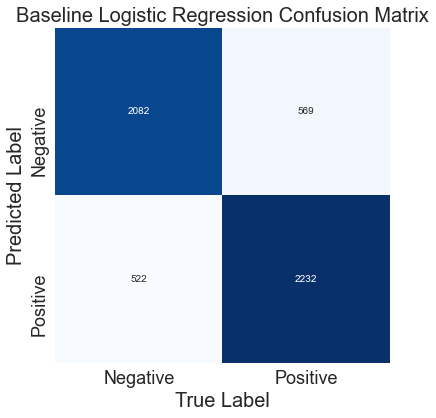

In [33]:
# Plotting a confusion matrix
plt.figure(figsize=(6, 7))
mat = confusion_matrix(y_test, y_pred_lr_cv)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cmap="Blues")
sns.set(font_scale=3.0)
plt.xlabel('True Label', fontsize= 20)
plt.ylabel('Predicted Label', fontsize= 20)
plt.title('Baseline Logistic Regression Confusion Matrix', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

The result are quite good for the first model. I checked cross validation to confirm that there is not underfitting or overfitting in the train set and the results were quite similar to the test set. Looking at the confusion matrix, we can see that the model classifies correctly 75% of both Negative and Positive reviews. A Random Forest model had a better accuracy than Logistic Regression. However, it had a lower F1 Score, which is the metric that I will be focusing further in the project. For this reason, I chose Logistic Regression as my best model. You can see below the performance of every model.

In [34]:
vanilla_models = pd.read_csv('csv/baseline-models_cv.csv', index_col=0)
vanilla_models.sort_values(by='Accuracy', ascending=False)

,Accuracy,Precision,Recall,F1 Score
Vanilla Random Forest CV,0.800370,0.837118,0.763299,0.798506
Vanilla Logisitic Regression CV,0.798150,0.810458,0.796858,0.803600
Vanilla SVC CV,0.783904,0.794234,0.786862,0.790531
Vanilla Naive Bayes CV,0.781129,0.793541,0.780793,0.787115


### Best Vanilla Model using TF-IDF Vectorizer

As I mentioned, I tried different TF-IDF Vectorizer as well. The best performing model was a Logistic Regression as well. Let's see the results.

In [35]:
# Importing train and test set using CountVectorizer
X_train_tfidf = pickle.load(open('pickle/X_train_tfidf.pkl', 'rb'))
X_test_tfidf = pickle.load(open('pickle/X_test_tfidf.pkl', 'rb'))
y_train_tfidf = pd.read_pickle('pickle/y_train.pkl')
y_test_tfidf = pd.read_pickle('pickle/y_test.pkl')

# Instantiating baseline Logistic Regression Model
lg_tfidf = LogisticRegression()

# Fitting the model to the X and y variables of the train set
lg_tfidf.fit(X_train_tfidf, y_train) 

# Predicting the model in the X variable of the test set
y_lg_base_tfidf = lg_tfidf.predict(X_test_tfidf)

In [36]:
# Logistic Regression TF-IDF baseline evaluation
evaluation(y_test, y_lg_base_tfidf)
cross_validation(lg_tfidf, X_train_tfidf, y_train, 5)

Evaluation Metrics:
Accuracy: 0.8170212765957446
Precision: 0.8481936971560338
Recall: 0.7879328811138879
F1 Score: 0.8169535443272257
Cross-Validation Accuracy Scores: [0.81776133 0.82269504 0.81591119 0.82146161 0.82973473]

Min:  0.815911
Max:  0.829735
Mean:  0.821513
Range:  0.013824


As we can see, TF-IDF vecotorizer was able to improve our model compared to CountVectorizer. The  was accuracy 0.8170. Let's compare all the models.

In [37]:
tfidf_models = pd.read_csv('csv/baseline-models_tfidf.csv', index_col=0)
tfidf_models.sort_values(by='Accuracy', ascending=False)

,Accuracy,Precision,Recall,F1 Score
Vanila Log Reg TF-IDF,0.817021,0.848194,0.787933,0.816954
Vanilla Random Forest CV,0.803885,0.843664,0.762942,0.801275
Vanilla Random Forest TF-IDF,0.801665,0.844285,0.756873,0.798193
Vanilla Logisitic Regression CV,0.798150,0.810458,0.796858,0.803600
Vanilla SVC CV,0.783904,0.794234,0.786862,0.790531
Vanilla Naive Bayes CV,0.781129,0.793541,0.780793,0.787115


Most of the vectorized training set had a better performance using TF-IDF performed better than CountVectorizer. The best model was was Logistic Regression using TF-IDF. It had an accuracy of 0.817 and an F1 Score of 0.8169. Looking at the cross-validation results, we can see that the model performed similartly across different folds. Having Logistic Regression as the best moel is great because we will be able to extract the most important features for both negative and positive predictions.

I also iterate Ensemble Models to find the best parameters. I was able to improve the best vanilla Logistic Regression model using GridSearch. Check the <a href='https://github.com/Ismaeltrevi/hotel-reviews-analysis-using-nlp/blob/main/models/ensemble-models.ipynb'>Ensemble Models</a> for more information about the process.

## Final Model

Logistic Regression was the best model with the highest accuracy and F1 Score between all the models. I was able to improve it a little bit using GridSearch. Let's see the result.

In [38]:
# Instantiating baseline Logistic Regression Model
lg_grid = LogisticRegression(C= 0.615848211066026, penalty='l2', warm_start=True)

# Fitting the model to the X and y variables of the train set
lg_grid.fit(X_train_tfidf, y_train) 

# Predicting the model in the X variable of the test set
y_pred_final = lg_grid.predict(X_test_tfidf)

In [39]:
# Logistic Regression TF-IDF baseline evaluation
evaluation(y_test, y_pred_final)
cross_validation(lg_grid, X_train_tfidf, y_train, 5)

Evaluation Metrics:
Accuracy: 0.8183163737280296
Precision: 0.8515655199072284
Recall: 0.7865048197072474
F1 Score: 0.8177431328878989
Cross-Validation Accuracy Scores: [0.81529448 0.82454517 0.81652791 0.82331175 0.82695867]

Min:  0.815294
Max:  0.826959
Mean:  0.821328
Range:  0.011664


As we can see, the model improved a tiny bit in every metric. Although the improvement is very small, it's still an improvement. 

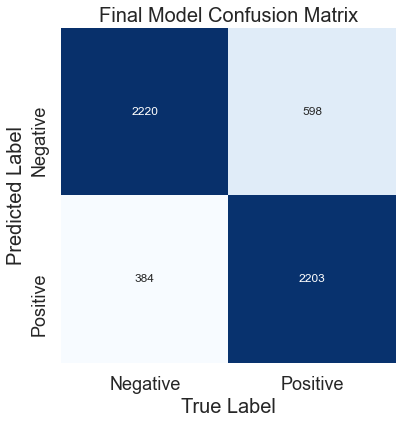

In [83]:
# Plotting a confusion matrix
plt.figure(figsize=(6, 7))
mat = confusion_matrix(y_test, y_pred_final)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cmap="Blues")
sns.set(font_scale=1.0)
plt.xlabel('True Label', fontsize= 20)
plt.ylabel('Predicted Label', fontsize= 20)
plt.title('Final Model Confusion Matrix', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('images/confusion-matrix-final-model_2.png', bbox_inches = "tight", pad_inches=.5, dpi=300)
plt.show()

Looking at the confusion matrix, we can see that the model needs improvements classifying Positive reviews, since it has a higher number of False Negatives compared to False Positives. Overall, the model performs well, but it has plenty of room for improvement for next steps of this project. Now, let's take a look at the 50most important features for each class using ELI5.

In [84]:
eli5.explain_weights(lg_tfidf, feature_names = X_train_tfidf.columns.values.tolist(), top=60)

Weight?,Feature
+6.092,excellent
+5.270,great
+5.082,amazing
+5.010,comfortable
+4.544,lovely
+4.222,bit
+4.150,perfect
+3.823,spacious
+3.818,loved
+3.596,friendly


In [61]:
positive_features = pickle.load(open('pickle/positive_features.pkl', 'rb'))
negative_features = pickle.load(open('pickle/negative_features.pkl', 'rb'))

Above we can see the top 25 most important features for each class. The green section contains the features with the highest weight for the positive class and the red-ish contains the features with the highest weight for the negative class. For the negative class feature predictors, the lower the weight of the feature, the highest is the importance and for the positive class feature predictor, the higher the weight Let's analyze the results.

### Top Features - Positive Class 

In [75]:
positive_features.transpose()

,Excellent,Great,Amazing,Comfortable,Lovely,Bit,Perfect,Spacious,Loved,Friendly,Wonderful,Fantastic,Quiet,Brilliant,Superb,Nice,Negative,Come,Beautiful,Modern,Helpful,Little,Large,Fabulous
0,6.092,5.27,5.082,5.01,4.544,4.222,4.15,3.823,3.818,3.596,3.407,3.221,2.963,2.935,2.896,2.685,2.674,2.61,2.56,2.482,2.424,2.266,2.235,2.234


The top features for predicting positive reviews weren't a surprise. Most of the features are adjectives that we can relate to positive reviews, such as excellent, great, and amazing. Although these words might not give much insight, some others are very related to hotels and can give us insights. Hotels should make sure that there are delivering this aspect to their guests. Let's check a few that I believe can carry insights:
- Comfortable: The most important aspect of a hotel is comfortable, so the guest can rest
- Bit: It doesn't carry much meaning
- Spacious: It's good when a hotel has a spacious room
- Friendly: It could be talking about how friendly the staff is, a very important aspect
- Quiet: It seems like quiet places are something that guests are looking for
- Negative: Although it is a negative word, I assume that the guests are saying that there isn't anything negative about the hotel
- Modern: Modern hotels seem to be noticed in the reviews
- Helpful: It's probably walking about the staff

### Top Features - Negative Class

In [85]:
negative_features.sort_values(by=0, ascending=False)

,0
Dirty,5.308
Rude,4.277
Terrible,3.543
Poor,3.451
Worst,3.248
Tired,3.230
Old,3.208
Bad,3.105
Basic,2.865
Uncomfortable,2.843


When looking at the top features for the negative class predictor, we can find words that everyone could expect from negative reviews such as awful, horrible, and bad. However, with the negative class feature predictor, we can have more insights and areas that every hotel should consider as critical. It's interesting to see that dirty has a higher weight than overpriced and dated. 
Let's take a look at a few features:

- Dirty: It's the most crucial feature when predicting negative reviews. This means that dirty is a giant red flag.
- Rude: Probably talking about the staff, which means that the hotel needs improvement in training
- Old: It's probably related to the hotel being outdated
- Overpriced: This is obvious to me. If people pay more money than they think it's worth, they will complain.


## Final Model Evaluation

Logistic Regression was the final model for its high accuracy and showed the feature importance for each class. The accuracy was 0.8183, which means that the model can correctly classify the target variable 81.83% of the time. Looking at cross-validation, we can see that the model performed similarly in the train set. I used 5 folds, and the range difference between the highest accuracy and lowest accuracy was a very small difference.

Looking at the confusion matrix, we can see that the overall performance is ok. However, it tends to predict more False Positives than False Negatives. There is definitely room for improvement as next steps.

# Final Recommendations

All models were trained with the reviews of over 1,400 hotels. Thus, the model can be used for any hotel because it used over 515k reviews. Britannia International Hotel Canary Wharf can use our model to correctly classify reviews at any point. However, the most important takeaways here is the feature importance. Since guests tend to expect for the same things in every hotel, we learned that words such as staff, location, comfortable, and dirty will make have a higher value in their reviews. The words also match to the word cloud create for Britannia International Hotel Canary Wharf, which proves that the hotel, similarly to other, need to focus on those words.

I recommend the hotel start using word clouds to get quick insights from negative and positive reviews. The negative reviews can be used to improve the business and should be used as soon as possible if the hotel wants to increase their overall score. The hotel should also use positive reviews can be used for advertisement, for example.

## Conclusion

- Machine learning can be used to identify positive and negative reviews correctly. However, identity with 100% confidence is difficult. My final model can be used for any hotel to find feature importance
- Word clouds can be used to understand what words appear the most in negative and positive reviews. The management can quickly take a look and get insights out of it.
- The Britannia International Hotel Canary Wharf performs poorly in the reviews compared to other hotels in London. There is a lot of room for improvement.

## Next Steps:

- Test the model in the whole data set as well as social media posts.
- Create a recommendation system to the user based on reviews
- Create a dashboard for guests and hotels easily get information about hotels.

## Repository Content

## For More Information or Suggestions
If you have any questions or suggestions, please reach me out.

Email: alves.trevi@gmail.com